In [1]:
#import src.h5Interface as h5i
#import src.reactorInterface as RI
import os
import pickle

from scipy.interpolate import interp1d as interp
from matplotlib import pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

import osbrain
from osbrain import run_nameserver
from osbrain import run_agent
from osbrain import logging
import numpy as np
import src.bb.blackboard as blackboard
import src.ka.base as ka
import src.ka.ka_s as karp
import src.ka.ka_brs as kabr
import src.bb.blackboard_optimization as bb_opt
import src.controller as controller
import time
import src.utils.performance_measure as pm
import math
import h5py
from sklearn.preprocessing import StandardScaler

import seaborn as sns

import numpy as np
import pandas as pd

In [2]:
def mean_std(results):
    mean = sum([x for x in results]) / len(results)
    var  = sum(pow(x-mean,2) for x in results) / len(results)
    std  = math.sqrt(var)
    return mean, std

def max_pf_val(results, objective):
    max_ = -1E10
    for core in results.values():
        max_ = core[objective] if core[objective] > max_ else max_
    return max_

def min_pf_val(results, objective):
    min_ = 1E10
    for core in results.values():
        min_ = core[objective] if core[objective] < min_ else min_
    return min_

def obj_range(min_, max_):
    return (max_ - min_)

def objective_range(results, objective):
    return max_pf_val(results, objective) - min_pf_val(results, objective)

def calculate_hvi(pf, ll, ul):
    hvi = pm.hypervolume_indicator(pf, ll, ul)
    return hvi

def calculate_dci(ll, ul, pfs, goal, div):
    dci = pm.diversity_comparison_indicator(ll, ul, pfs, goal=goal, div=div)
    return dci

def read_ga_pf(ga_file, design_variables, objectives, num, goal):
    ga_dir = '/Users/ryanstewart/projects/Dakota_interface/' + ga_file 
    f = open(ga_dir + 'f_{}.dat'.format(num))
    ga_pf = {}

    for line in f:
        split_line = line.split('\t')
        split_line = [float(x) for x in split_line]
        name = 'core_[{}, {}, {}]'.format(split_line[0], split_line[1], split_line[2])
        ga_pf[name] = {}
#        for n, dv in enumerate(design_variables.keys()):
 #           ga_pf[name].update({dv: split_line[n]})
        for n, obj in enumerate(objectives.keys()):
            ga_pf[name].update({obj: split_line[n+len(design_variables)]})

    f.close()
    f = open(ga_dir + 'bu_rxs_comp_{}.out'.format(num, 'r'))
    for line in f:
        if 'wall clock' in line:
            split_line = line.split('  ')
            ga_time = float(split_line[-1])
    f.close()
                
    pf = [[-core[obj] if goal[obj] == 'gt' else core[obj] for obj in objectives.keys()] for core in ga_pf.values()]
    ga_hvi = calculate_hvi(pf, [x['ll'] for x in objectives.values()], [x['ul'] for x in objectives.values()])

    return ga_pf, ga_time, ga_hvi

def read_pymoo_pf(pymoo_file, objectives, num, goal):
    with open('./{}.pkl'.format(pymoo_file), 'rb') as pickle_file:
        pymoo_outs = pickle.load(pickle_file)    
    hvi_list = []
    pymoo_dict = {}
    hvi = pm.hypervolume_indicator(pymoo_outs[num][0], [x['ll'] for x in objectives.values()], [x['ul'] for x in objectives.values()])
    for core in pymoo_outs[num][0]:
        pymoo_dict['core_{}'.format(np.random.random())] = {obj: -core[num] if goal[obj] == 'gt' else core[num] for num, obj in enumerate(objectives.keys())}       
    
    return pymoo_dict, pymoo_outs[num][1], hvi
        
def read_bb_pf(bb_file, design_variables, objectives, num, goal, dci=True):
    ns = run_nameserver()
    bb = run_agent(name='bb', base=bb_opt.BbOpt)
    bb.set_attr(archive_name=bb_file+'{}.h5'.format(num))
    bb.load_h5(panels={2:['new','old'],3:['new','old']})
    lvls = bb.get_attr('abstract_lvls')
    lvl1 = lvls['level 1']    
    lvl3 = {}
    for name in lvls['level 3'].values():
        lvl3.update(name)
    bb_pf = {}
    for name, rx_parameters in lvl1.items():
        bb_pf[name] = {}
        print(dci, bb_pf)
        if not dci:
            for num, dv in enumerate(design_variables.keys()):
                bb_pf[name].update({dv: lvl3[name]['design variables'][dv]})
        for num, obj in enumerate(objectives.keys()):
            bb_pf[name].update({obj: lvl3[name]['objective functions'][obj]})
    meta_data = lvls['level 100']['final']
    
    pf = [[-core[obj] if goal[obj] == 'gt' else core[obj] for obj in objectives.keys()] for core in bb_pf.values()]
    bb_hvi = calculate_hvi(pf, [x['ll'] for x in objectives.values()], [x['ul'] for x in objectives.values()])

    ns.shutdown()
    time.sleep(1)
    return bb_pf, meta_data['time'], bb_hvi

def compare_results_2(num_to_compare, dir_1, dir_2, objectives, design_variabes, div, compare=['bb', 'pymoo'], dci=True):
    pfs_1 = {}
    bb_pfs = {}
    full_pf = []
    goal = {k:v['goal'] for k,v in objectives.items()}
    ll = {obj_name: obj['ll'] for obj_name, obj in objectives.items()}
    ul = {obj_name: obj['ul'] for obj_name, obj in objectives.items()}
    
    for i in range(num_to_compare):
        if 'pymoo' in compare:
            pf1, time1, hvi1 = read_pymoo_pf(dir_1, objectives, i, goal)   
            full_pf.append(pf1)            
            pfs_1[i] = {'pf': pf1, 'time': time1, 'hvi': hvi1}
        if 'dakota' in compare:
            ga_pf, ga_time, ga_hvi = read_ga_pf(ga_dir, design_variables, objectives, i, goal)        
            full_pf.append(ga_pf)
            pfs_1[i] = {'pf': ga_pf, 'time': ga_time, 'hvi': ga_hvi}
        if 'bb' in compare:
            bb_pf, bb_time, bb_hvi = read_bb_pf(dir_2, design_variables, objectives, i, goal)
            full_pf.append(bb_pf)
            bb_pfs[i] = {'pf': bb_pf, 'time': bb_time, 'hvi': bb_hvi}
    if dci:
        dci_object = calculate_dci(ll, ul, full_pf, goal, div) 
        for i in range(num_to_compare):
            dci_object.compute_dci(pfs_1[i]['pf'])
            pfs_1[i].update({'dci': dci_object.dci})

            dci_object.compute_dci(bb_pfs[i]['pf'])
            bb_pfs[i].update({'dci': dci_object.dci})
    
    return pfs_1, bb_pfs

def compare_results(num_to_compare, ga_dir, bb_dir, objectives, design_variabes, div, goal):
    ga_pfs = {}
    bb_pfs = {}
    full_pf = []
    for i in range(num_to_compare):
        try:
            ga_pf, ga_time, ga_hvi = read_ga_pf(ga_dir, design_variables, objectives, i, goal)        
            full_pf.append(ga_pf)
            ga_pfs[i] = {'pf': ga_pf, 'time': ga_time, 'hvi': ga_hvi}
        except:
            print('Failed to load ga {}'.format(i))
        bb_pf, bb_time, bb_hvi = read_bb_pf(bb_dir, design_variables, objectives, i, goal)
        full_pf.append(bb_pf)
        bb_pfs[i] = {'pf': bb_pf, 'time': bb_time, 'hvi': bb_hvi}

    ll = {obj_name: obj['ll'] for obj_name, obj in objectives.items()}
    ul = {obj_name: obj['ul'] for obj_name, obj in objectives.items()}

#    dci_object = calculate_dci(ll, ul, full_pf, goal, div)
#    for i in range(num_to_compare):
#        dci_object.compute_dci(ga_pfs[i]['pf'])
#        ga_pfs[i].update({'dci': dci_object.dci})
#        dci_object.compute_dci(bb_pfs[i]['pf'])
#        print(dci_object.dci)
#        bb_pfs[i].update({'dci': dci_object.dci})
    
    return ga_pfs, bb_pfs

def get_objectives_in_level(lvl):
    obj_dict = {}
    
    for core, values in lvl_3.items():
        if core in lvl:
            dvs = values['design variables']
            core_params = values['objective functions']
            core_con = values['constraints']
            
            for dv in bb.get_attr('design_variables').keys():
                if dv in obj_dict.keys():
                    obj_dict[dv].append(dvs[dv])
                else:
                    obj_dict[dv] = [dvs[dv]] 
            for obj in bb.get_attr('objectives').keys():
                if obj in obj_dict.keys():
                    obj_dict[obj].append(core_params[obj])
                else:
                    obj_dict[obj] = [core_params[obj]]
            for obj in bb.get_attr('constraints').keys():
                if obj in obj_dict.keys():
                    obj_dict[obj].append(core_con[obj])
                else:
                    obj_dict[obj] = [core_con[obj]]
    return obj_dict

def get_non_pareto_sols():
    obj_dict = {}
    
    for core, values in lvl_2.items():
        if core not in lvl_1:
            dvs = lvl_3[core]['design variables']
            core_params = lvl_3[core]['objective functions']
            for dv in bb.get_attr('design_variables'):
                if dv in obj_dict.keys():
                    obj_dict[dv].append(dvs[dv])
                else:
                    obj_dict[dv] = [dvs[dv]] 
            for obj in bb.get_attr('objectives').keys():
                if obj in obj_dict.keys():
                    obj_dict[obj].append(core_params[obj])
                else:
                    obj_dict[obj] = [core_params[obj]]
    return obj_dict

def get_objectives_not_in_level(lvl):
    obj_dict = {}

    for core, values in lvl_3.items():
        if core not in lvl:
            dvs = values['design variables']
            core_params = values['objective functions']
            for dv in bb.get_attr('design_variables'):
                if dv in obj_dict.keys():
                    obj_dict[dv].append(dvs[dv])
                else:
                    obj_dict[dv] = [dvs[dv]]                
            for obj in bb.get_attr('objectives').keys():
                if obj in obj_dict.keys():
                    obj_dict[obj].append(core_params[obj])
                else:
                    obj_dict[obj] = [core_params[obj]]
    return obj_dict

def make_2d_fig(x_obj, y_obj, null=False):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=lvl_1_obj[x_obj], y=lvl_1_obj[y_obj], mode='markers', name='pareto'))
    if null == True:
        fig.add_trace(go.Scatter(x=null_space[x_obj], y=null_space[y_obj], mode='markers', name='null'))
    fig.update_xaxes(title_text=obj_labels[x_obj])
    fig.update_yaxes(title_text=obj_labels[y_obj])
    fig.show()

def make_3d_fig(x_obj, y_obj, z_obj, null=False):
    fig = go.Figure()
    fig.add_trace(go.Scatter3d(x=lvl_1_obj[x_obj], y=lvl_1_obj[y_obj], z=lvl_1_obj[z_obj], mode='markers', name='pareto'))
    if null == True:
        fig.add_trace(go.Scatter3d(x=null_space[x_obj], y=null_space[y_obj], z=null_space[z_obj], mode='markers', name='null'))
    fig.update_layout(scene={'xaxis': {'title': obj_labels[x_obj]}, 'yaxis':{'title': obj_labels[y_obj]},'zaxis':{'title': obj_labels[z_obj]},})
    fig.show()
    
def make_dv_histogram(bins, mean_=False):
    for num, dv in enumerate(bb.get_attr('design_variables').keys()):
        mean, std_dev = mean_std(lvl_1_obj[dv])
        fig = go.Figure()
        fig.add_trace(go.Histogram(x=lvl_1_obj[dv], histnorm='probability',xbins=bins[num]))
        if mean_:
            fig.add_shape(dict(
            type="line",
            x0=mean,
            y0=0,
            x1=mean,
            y1=1.0,
            line=dict(
                color="goldenrod",
                width=3)))
    
            layout = go.Layout(annotations = [dict(x=mean,
            y=1,
            xref='x',
            yref='paper',
            text="Mean: {}".format(round(mean,3)),
            showarrow=True,
            arrowhead=7,
            ax=1,
            ay=1)])
            fig.update_layout(layout)
            fig.update_shapes(dict(yref='paper'))
        fig.update_xaxes(title_text=obj_labels[dv],title_font=dict(size=16),tickfont=dict(size=14))
        fig.update_yaxes(title_text='Probability',title_font=dict(size=16),tickfont=dict(size=14))
        fig.show()
        
obj_labels = {'fitness': 'fitness',
              'burnup': 'Burnup (GWD/MTHM)',
              'cycle length': 'Cycle Length (days)',
              'pu mass': 'Plutonium Mass (kg/cycle)',
              'reactivity swing' : 'Reactivity Swing (pcm/month)',
              'height': 'Height (cm)',
              'smear': 'Smear',
              'pu_content': 'Pu Frac.',
              'void': 'Void Coeff. (pcm/%void)',
              'doppler': 'Doppler Coeff. (pcm/K)',
              'excess reactivity': 'Excess Reactivity (pcm)',
              'pu ratio': 'Pu239/Pu',
              'pu240 ratio': 'Pu240/Pu239',
              'pu disposed': 'Plutonium Disposed (kg/cycle)',
              'max lhgr': 'Max LHGR (W/m)'}
design_variables = {'height':     {'ll': 50.0, 'ul': 100.0, 'variable type': float},
                    'smear':      {'ll': 50.0, 'ul': 80.0, 'variable type': float},
                    'pu_content': {'ll': 0.0,  'ul': 1.0,  'variable type': float}}
full_div = {'reactivity swing': 125, 'burnup':100, 'pu mass': 250, 'pu ratio': 200, 'pu disposed': 100}


In [ ]:
objective_3d = {'reactivity swing': {'ll':250,  'ul':1500,  'goal':'lt', 'variable type': float},
                'burnup':           {'ll':-150,   'ul':-50,    'goal':'gt', 'variable type': float},
                'pu mass':          {'ll':0,    'ul':1000,  'goal':'lt', 'variable type': float}}
objective_2d = {'reactivity swing': {'ll':500,  'ul':1500,  'goal':'lt', 'variable type': float},
                'burnup':           {'ll':-150,   'ul':-50,    'goal':'gt', 'variable type': float}}
design_variables = {'height':     {'ll': 50.0, 'ul': 100.0, 'variable type': float},
                    'smear':      {'ll': 50.0, 'ul': 80.0, 'variable type': float},
                    'pu_content': {'ll': 0.0,  'ul': 1.0,  'variable type': float}}
full_div = {'reactivity swing': 125, 'burnup':100, 'pu mass': 250, 'pu ratio': 200, 'pu disposed': 100}
div_2d={'reactivity swing': 250, 'burnup':100}       
div_3d={'reactivity swing':  150, 'burnup':  100, 'pu mass': 100}        
bb_file_2d = 'sa_2d_pymoo/2d_sa_'
ga_file_2d = 'pymoo_2d_results'
bb_file_3d = 'sa_3d/3d_sa_'
ga_file_3d = 'pymoo_3d_results'


#ga, bb = compare_results_2(20, ga_file_2d, bb_file_2d, objective_2d, design_variables, full_div, compare=['bb', 'pymoo'] )
ga, bb = compare_results_2(20, ga_file_3d, bb_file_3d, objective_3d, design_variables, full_div)
#ga, bb = compare_results(4, ga_file_2d, bb_file_2d, objective_2d, design_variables, div_2d, goal_2d)


# 2D Analysis Results

In [ ]:
objective_2d = {'reactivity swing': {'ll':500,  'ul':1500,  'goal':'lt', 'variable type': float},
                'burnup':           {'ll':-150,   'ul':-50,    'goal':'gt', 'variable type': float}}

bb_file_2d = 'sa_2d_pymoo_5000/2d_sa_'
ga_file_2d = 'pymoo_2d_results_base_5000'
ga, bb = compare_results_2(20, ga_file_2d, bb_file_2d, objective_2d, design_variables, full_div, compare=['bb', 'pymoo'] )

hvi = mean_std([x['hvi'] for x in bb.values()])
dci = mean_std([x['dci'] for x in bb.values()])
time_ = mean_std([x['time'] for x in bb.values()])
s_rx = mean_std([objective_range(x['pf'], 'reactivity swing') for x in bb.values()])
s_bu = mean_std([objective_range(x['pf'], 'burnup') for x in bb.values()])
size_ = mean_std([len(x['pf']) for x in bb.values()])
print(size_)
print('ABBS & {} ({}) & {} ({}) & {} ({}) &  {} ({}) & {} ({}) \\\ '.format(round(hvi[0], 4), round(hvi[1], 4), 
                                                                     round(dci[0], 3), round(dci[1], 3),
                                                                     int(s_rx[0]), int(s_rx[1]),
                                                                     round(s_bu[0], 1), round(s_bu[1], 1),
                                                                     int(time_[0]), int(time_[1])))
hvi = mean_std([x['hvi'] for x in ga.values()])
dci = mean_std([x['dci'] for x in ga.values()])
time_ = mean_std([x['time'] for x in ga.values()])
s_rx = mean_std([objective_range(x['pf'], 'reactivity swing') for x in ga.values()])
s_bu = mean_std([objective_range(x['pf'], 'burnup') for x in ga.values()])
size_ = mean_std([len(x['pf']) for x in ga.values()])
print(size_)
print('NSGA-II & {} ({}) & {} ({}) & {} ({}) &  {} ({}) & {} ({})  \\\ '.format(round(hvi[0], 4), round(hvi[1], 4), 
                                                                     round(dci[0], 3), round(dci[1], 3),
                                                                     int(s_rx[0]), int(s_rx[1]),
                                                                     round(s_bu[0], 1), round(s_bu[1], 1),
                                                                     int(time_[0]), int(time_[1])))


# 3D Analysis Results

In [12]:
objective_3d = {'reactivity swing': {'ll':250,  'ul':1500,  'goal':'lt', 'variable type': float},
                'burnup':           {'ll':-150,   'ul':-50,    'goal':'gt', 'variable type': float},
                'pu mass':          {'ll':0,    'ul':1000,  'goal':'lt', 'variable type': float}}

bb_file_3d = 'sa_3d_5000/3d_sa_'
ga_file_3d = 'pymoo_3d_results'
ga, bb = compare_results_2(20, ga_file_3d, bb_file_3d, objective_3d, design_variables, full_div)

hvi = mean_std([x['hvi'] for x in bb.values()])
dci = mean_std([x['dci'] for x in bb.values()])
time_ = mean_std([x['time'] for x in bb.values()])
s_rx = mean_std([objective_range(x['pf'], 'reactivity swing') for x in bb.values()])
s_bu = mean_std([objective_range(x['pf'], 'burnup') for x in bb.values()])
s_pu = mean_std([objective_range(x['pf'], 'pu mass') for x in bb.values()])
size_ = mean_std([len(x['pf']) for x in bb.values()])
print(size_)
print('ABBS & {} ({}) & {} ({}) & {} ({}) &  {} ({}) & {} ({}) & {} ({}) \\\ '.format(round(hvi[0], 4), round(hvi[1], 4), 
                                                                     round(dci[0], 3), round(dci[1], 3),
                                                                     int(s_rx[0]), int(s_rx[1]),
                                                                     round(s_bu[0], 1), round(s_bu[1], 1),
                                                                     round(s_pu[0], 1), round(s_pu[1], 1),
                                                                     int(time_[0]), int(time_[1])))
hvi = mean_std([x['hvi'] for x in ga.values()])
dci = mean_std([x['dci'] for x in ga.values()])
time_ = mean_std([x['time'] for x in ga.values()])
s_rx = mean_std([objective_range(x['pf'], 'reactivity swing') for x in ga.values()])
s_bu = mean_std([objective_range(x['pf'], 'burnup') for x in ga.values()])
s_pu = mean_std([objective_range(x['pf'], 'pu mass') for x in ga.values()])
size_ = mean_std([len(x['pf']) for x in ga.values()])
print(size_)
print('NSGA-II & {} ({}) & {} ({}) & {} ({}) &  {} ({}) & {} ({}) & {} ({}) \\\ '.format(round(hvi[0], 4), round(hvi[1], 4), 
                                                                     round(dci[0], 3), round(dci[1], 3),
                                                                     int(s_rx[0]), int(s_rx[1]),
                                                                     round(s_bu[0], 1), round(s_bu[1], 1),
                                                                     round(s_pu[0], 1), round(s_pu[1], 1),
                                                                     int(time_[0]), int(time_[1])))


Broadcast server running on 0.0.0.0:9091
NS running on 127.0.0.1:16752 (127.0.0.1)
URI = PYRO:Pyro.NameServer@127.0.0.1:16752
INFO [2021-02-23 02:50:17.914226] (bb): Loading H5 archive: sa_3d_5000/3d_sa_0.h5


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



NS shut down.
Broadcast server running on 0.0.0.0:9091
NS running on 127.0.0.1:12937 (127.0.0.1)
URI = PYRO:Pyro.NameServer@127.0.0.1:12937
INFO [2021-02-23 02:50:54.801814] (bb): Loading H5 archive: sa_3d_5000/3d_sa_1.h5


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



NS shut down.
Broadcast server running on 0.0.0.0:9091
NS running on 127.0.0.1:15645 (127.0.0.1)
URI = PYRO:Pyro.NameServer@127.0.0.1:15645
INFO [2021-02-23 02:51:38.488796] (bb): Loading H5 archive: sa_3d_5000/3d_sa_2.h5


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




True {'core_[51.706964569589935,79.31206687309307,0.11872079934673242]': {'reactivity swing': 653.1131401129398, 'burnup': 72.23435510506533, 'pu mass': 20.909446210328774}, 'core_[52.0826066585461,79.93527325928873,0.08764365340032693]': {'reactivity swing': 641.553087503869, 'burnup': 71.33595315212963, 'pu mass': 17.762411002930406}, 'core_[52.143791859576915,78.27288053819817,0.1572003545315949]': {'reactivity swing': 659.4130101083819, 'burnup': 72.60590824928596, 'pu mass': 24.968233507857086}, 'core_[52.34432233318435,78.13050932923863,0.15517979474777882]': {'reactivity swing': 658.0798539694589, 'burnup': 72.50827195368066, 'pu mass': 24.5986975192151}, 'core_[52.3902460067324,79.25067682712333,0.11983167623995306]': {'reactivity swing': 644.3395371576385, 'burnup': 71.49860780726083, 'pu mass': 21.1043656935555}, 'core_[52.39430691031941,79.89189286440822,0.059831666088741055]': {'reactivity swing': 638.4817480352659, 'burnup': 71.11620010120072, 'pu mass': 14.2546936812724}

NS shut down.
Broadcast server running on 0.0.0.0:9091
NS running on 127.0.0.1:19703 (127.0.0.1)
URI = PYRO:Pyro.NameServer@127.0.0.1:19703
INFO [2021-02-23 02:52:24.824254] (bb): Loading H5 archive: sa_3d_5000/3d_sa_3.h5


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



NS shut down.
Broadcast server running on 0.0.0.0:9091
NS running on 127.0.0.1:16892 (127.0.0.1)
URI = PYRO:Pyro.NameServer@127.0.0.1:16892
INFO [2021-02-23 02:53:17.268583] (bb): Loading H5 archive: sa_3d_5000/3d_sa_4.h5


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



NS shut down.
Broadcast server running on 0.0.0.0:9091
NS running on 127.0.0.1:19522 (127.0.0.1)
URI = PYRO:Pyro.NameServer@127.0.0.1:19522
INFO [2021-02-23 02:54:06.172943] (bb): Loading H5 archive: sa_3d_5000/3d_sa_5.h5


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



NS shut down.
Broadcast server running on 0.0.0.0:9091
NS running on 127.0.0.1:14951 (127.0.0.1)
URI = PYRO:Pyro.NameServer@127.0.0.1:14951
INFO [2021-02-23 02:54:53.338176] (bb): Loading H5 archive: sa_3d_5000/3d_sa_6.h5


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



NS shut down.
Broadcast server running on 0.0.0.0:9091
NS running on 127.0.0.1:15933 (127.0.0.1)
URI = PYRO:Pyro.NameServer@127.0.0.1:15933
INFO [2021-02-23 02:55:42.451682] (bb): Loading H5 archive: sa_3d_5000/3d_sa_7.h5


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



NS shut down.
Broadcast server running on 0.0.0.0:9091
NS running on 127.0.0.1:16211 (127.0.0.1)
URI = PYRO:Pyro.NameServer@127.0.0.1:16211
INFO [2021-02-23 02:56:22.538620] (bb): Loading H5 archive: sa_3d_5000/3d_sa_8.h5


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




True {'core_[51.733486750388664,79.43870183570519,0.08810514228862865]': {'reactivity swing': 651.4556944063738, 'burnup': 72.17609810522674, 'pu mass': 17.14494718913579}, 'core_[52.22080335820073,77.53205963885884,0.12994577881150174]': {'reactivity swing': 665.9066999940344, 'burnup': 73.31034547949685, 'pu mass': 20.52407401358502}, 'core_[52.22080335820073,77.78165105390978,0.12008300370641739]': {'reactivity swing': 662.8457073057385, 'burnup': 73.08764908205318, 'pu mass': 19.455155309253406}, 'core_[52.22080335820073,78.15042077070474,0.11316996527530493]': {'reactivity swing': 658.5767759534139, 'burnup': 72.74598700672693, 'pu mass': 18.9292078751658}, 'core_[52.30714587912472,77.8227389768262,0.1275505657365113]': {'reactivity swing': 661.2344759882299, 'burnup': 72.92292681492137, 'pu mass': 20.51461983057426}, 'core_[52.40567108719863,78.929101,0.08786603928104]': {'reactivity swing': 647.5706251041195, 'burnup': 71.86912574414124, 'pu mass': 16.552674654047976}, 'core_[5

NS shut down.
Broadcast server running on 0.0.0.0:9091
NS running on 127.0.0.1:17688 (127.0.0.1)
URI = PYRO:Pyro.NameServer@127.0.0.1:17688
INFO [2021-02-23 02:57:16.369613] (bb): Loading H5 archive: sa_3d_5000/3d_sa_9.h5


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



NS shut down.
Broadcast server running on 0.0.0.0:9091
NS running on 127.0.0.1:19114 (127.0.0.1)
URI = PYRO:Pyro.NameServer@127.0.0.1:19114
INFO [2021-02-23 02:57:57.930989] (bb): Loading H5 archive: sa_3d_5000/3d_sa_10.h5


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



NS shut down.
Broadcast server running on 0.0.0.0:9091
NS running on 127.0.0.1:14865 (127.0.0.1)
URI = PYRO:Pyro.NameServer@127.0.0.1:14865
INFO [2021-02-23 02:58:47.249337] (bb): Loading H5 archive: sa_3d_5000/3d_sa_11.h5


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




True {'core_[51.830042597404095,79.48617289380982,0.08983416576606554]': {'reactivity swing': 649.5975771475595, 'burnup': 72.01696445628721, 'pu mass': 17.433006502975744}, 'core_[51.83471643169859,78.7401532969411,0.13275836120849355]': {'reactivity swing': 657.757393107027, 'burnup': 72.58545533368557, 'pu mass': 22.10757123631531}, 'core_[51.940144221712416,78.55236447582419,0.14871990380798497]': {'reactivity swing': 658.8239404975401, 'burnup': 72.59969133438287, 'pu mass': 24.061117224658886}, 'core_[52.08572225725917,79.98903484825662,0.11066988816977757]': {'reactivity swing': 640.8729195186155, 'burnup': 71.2144628123623, 'pu mass': 20.7774626036776}, 'core_[52.310433056738745,79.53167975293916,0.08362435077984526]': {'reactivity swing': 642.6357182914088, 'burnup': 71.44784456356751, 'pu mass': 16.751698081950238}, 'core_[52.31200924490122,77.08106120987114,0.14116646953018358]': {'reactivity swing': 670.2246151698826, 'burnup': 73.62691161570874, 'pu mass': 21.635420322843

NS shut down.
Broadcast server running on 0.0.0.0:9091
NS running on 127.0.0.1:16851 (127.0.0.1)
URI = PYRO:Pyro.NameServer@127.0.0.1:16851
INFO [2021-02-23 02:59:40.816514] (bb): Loading H5 archive: sa_3d_5000/3d_sa_12.h5


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



NS shut down.
Broadcast server running on 0.0.0.0:9091
NS running on 127.0.0.1:17501 (127.0.0.1)
URI = PYRO:Pyro.NameServer@127.0.0.1:17501
INFO [2021-02-23 03:00:39.427354] (bb): Loading H5 archive: sa_3d_5000/3d_sa_13.h5


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




True {'core_[51.487945566236746,79.7578371232953,0.11569585125514048]': {'reactivity swing': 651.4050695231668, 'burnup': 72.08396900024152, 'pu mass': 21.034275095283476}, 'core_[51.590679,79.84814005425704,0.0747750094663682]': {'reactivity swing': 649.3702453765652, 'burnup': 72.00768720732037, 'pu mass': 15.99929173576858}, 'core_[51.9147715653031,79.44682870605179,0.08000081615507526]': {'reactivity swing': 649.0127049511959, 'burnup': 71.98626026959926, 'pu mass': 16.15126929290396}, 'core_[52.08382201551236,79.99112674709124,0.06121496855056119]': {'reactivity swing': 641.6064059321459, 'burnup': 71.37181432898326, 'pu mass': 14.546313132235895}, 'core_[52.122892061244364,79.69384112431756,0.08000081615507526]': {'reactivity swing': 643.5931792505328, 'burnup': 71.52792926321024, 'pu mass': 16.48649460764105}, 'core_[52.20958699898415,79.96573069218326,0.07139540586323487]': {'reactivity swing': 639.8602148290095, 'burnup': 71.21957346540508, 'pu mass': 15.776128581079561}, 'co

NS shut down.
Broadcast server running on 0.0.0.0:9091
NS running on 127.0.0.1:15340 (127.0.0.1)
URI = PYRO:Pyro.NameServer@127.0.0.1:15340
INFO [2021-02-23 03:01:29.013811] (bb): Loading H5 archive: sa_3d_5000/3d_sa_14.h5


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




True {'core_[51.90340253186659,78.56873545818698,0.1518668030071737]': {'reactivity swing': 659.2816706551313, 'burnup': 72.61975873636912, 'pu mass': 24.49511913969375}, 'core_[52.13809397968425,79.82403963047801,0.08883862487640927]': {'reactivity swing': 641.9113828084837, 'burnup': 71.36757694656355, 'pu mass': 17.773602422109548}, 'core_[52.2326078063185,78.46150355070704,0.12321489897632162]': {'reactivity swing': 655.0338392769229, 'burnup': 72.40592837226976, 'pu mass': 20.60584520088456}, 'core_[52.24948005196137,79.0229165145668,0.09906389581632499]': {'reactivity swing': 648.6119577358369, 'burnup': 71.92997969242526, 'pu mass': 18.090412957641675}, 'core_[52.26529082617822,79.01367634769865,0.12321489897632162]': {'reactivity swing': 648.598864017294, 'burnup': 71.85015402864194, 'pu mass': 21.24533888173471}, 'core_[52.483357662726604,57.9076290281181,0.9922148922519625]': {'reactivity swing': 1063.662910929407, 'burnup': 96.38634989690735, 'pu mass': 111.02026575429225},

NS shut down.
Broadcast server running on 0.0.0.0:9091
NS running on 127.0.0.1:13250 (127.0.0.1)
URI = PYRO:Pyro.NameServer@127.0.0.1:13250
INFO [2021-02-23 03:02:20.041870] (bb): Loading H5 archive: sa_3d_5000/3d_sa_15.h5


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



NS shut down.
Broadcast server running on 0.0.0.0:9091
NS running on 127.0.0.1:19376 (127.0.0.1)
URI = PYRO:Pyro.NameServer@127.0.0.1:19376
INFO [2021-02-23 03:03:15.910659] (bb): Loading H5 archive: sa_3d_5000/3d_sa_16.h5


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




True {'core_[51.88527358200209,79.0581423418605,0.09119353348526792]': {'reactivity swing': 653.381596808336, 'burnup': 72.34337095060405, 'pu mass': 17.079214999076356}, 'core_[51.9574729853133,79.80652050378858,0.0918469383655718]': {'reactivity swing': 644.5060858219057, 'burnup': 71.57758658038217, 'pu mass': 18.11262995724404}, 'core_[51.96300143455991,79.39567608807668,0.1013056543411856]': {'reactivity swing': 648.6217756599272, 'burnup': 71.91259943031943, 'pu mass': 18.798232057502325}, 'core_[52.07318495647201,78.92344954244459,0.1013056543411856]': {'reactivity swing': 652.1226849154524, 'burnup': 72.22031409462689, 'pu mass': 18.237506856332885}, 'core_[52.37657655723381,79.99555621416982,0.06137125132331046]': {'reactivity swing': 637.6251324604897, 'burnup': 71.04123937952014, 'pu mass': 14.58395463449554}, 'core_[52.41622176226274,62.67576441895834,0.7313903863957182]': {'reactivity swing': 938.6744027219008, 'burnup': 89.34322139234082, 'pu mass': 87.78304290330233}, '

NS shut down.
Broadcast server running on 0.0.0.0:9091
NS running on 127.0.0.1:17630 (127.0.0.1)
URI = PYRO:Pyro.NameServer@127.0.0.1:17630
INFO [2021-02-23 03:04:05.458605] (bb): Loading H5 archive: sa_3d_5000/3d_sa_17.h5


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




True {'core_[51.73871874045121,79.83403120614328,0.08261186807023535]': {'reactivity swing': 647.3329868188185, 'burnup': 71.82878658664896, 'pu mass': 16.964958750365213}, 'core_[51.73943736824869,79.35230634982484,0.11391948693992722]': {'reactivity swing': 652.1918043447272, 'burnup': 72.17308060696269, 'pu mass': 20.34020133352118}, 'core_[52.19191221064903,77.93868302794054,0.1745709982764617]': {'reactivity swing': 663.4490290236132, 'burnup': 72.83463500118305, 'pu mass': 27.03559202563045}, 'core_[52.26504917655012,78.79795060810409,0.09291366524654947]': {'reactivity swing': 650.8684195296787, 'burnup': 72.13828808735886, 'pu mass': 17.02891712729142}, 'core_[52.396588471189666,79.0780914797228,0.11588905964211794]': {'reactivity swing': 646.0141846308596, 'burnup': 71.65945416896507, 'pu mass': 20.37783148548379}, 'core_[52.396588471189666,79.46606677909573,0.11457342754005853]': {'reactivity swing': 641.9776238235713, 'burnup': 71.31310155437004, 'pu mass': 20.6762404580426

NS shut down.
Broadcast server running on 0.0.0.0:9091
NS running on 127.0.0.1:18032 (127.0.0.1)
URI = PYRO:Pyro.NameServer@127.0.0.1:18032
INFO [2021-02-23 03:04:57.677791] (bb): Loading H5 archive: sa_3d_5000/3d_sa_18.h5


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



NS shut down.
Broadcast server running on 0.0.0.0:9091
NS running on 127.0.0.1:17841 (127.0.0.1)
URI = PYRO:Pyro.NameServer@127.0.0.1:17841
INFO [2021-02-23 03:05:39.143555] (bb): Loading H5 archive: sa_3d_5000/3d_sa_19.h5


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




True {'core_[51.65582242605785,79.42375516789444,0.085625110942608]': {'reactivity swing': 652.7279575715983, 'burnup': 72.28634623759909, 'pu mass': 16.806740470113226}, 'core_[52.01833474925313,78.77558768119763,0.11949171279282866]': {'reactivity swing': 654.5577802696437, 'burnup': 72.37136056954846, 'pu mass': 20.42925714711903}, 'core_[52.01833474925313,79.10904241902666,0.11949171279282866]': {'reactivity swing': 650.9617507915809, 'burnup': 72.05956421225433, 'pu mass': 20.820700480044025}, 'core_[52.219417018447935,79.13144445578385,0.0883445305480394]': {'reactivity swing': 647.990222577369, 'burnup': 71.89791379131849, 'pu mass': 16.840785456869753}, 'core_[52.437207732509066,60.70011641600647,0.8464304159656582]': {'reactivity swing': 987.2485178341738, 'burnup': 92.08167246730414, 'pu mass': 98.7663868336922}, 'core_[52.437207732509066,61.70626648808608,0.8464304159656582]': {'reactivity swing': 966.6775930162901, 'burnup': 90.55317097948915, 'pu mass': 100.40834456500812

NS shut down.
(360.75, 36.105228153274425)
ABBS & 0.2851 (0.0029) & 0.484 (0.012) & 645 (14) &  45.8 (0.9) & 111.4 (2.2) & 89 (12) \\ 
(100.0, 0.0)
NSGA-II & 0.2954 (0.0055) & 0.522 (0.027) & 764 (31) &  59.2 (1.8) & 106.9 (5.5) & 2 (0) \\ 


In [ ]:
(331.2, 31.789306378088842)
ABBS & 0.2834 (0.0033) & 0.558 (0.015) & 640 (13) &  45.3 (1.0) & 112.5 (0.5) & 83 (13) \\ 
(100.0, 0.0)
NSGA-II & 0.2938 (0.007) & 0.563 (0.022) & 757 (38) &  58.7 (2.3) & 106.7 (6.6) & 2 (0) \\ 

(361.0, 0.0)
ABBS & 0.2862 (0.0) & 0.725 (0.0) & 651 (0) &  46.1 (0.0) & 111.9 (0.0) & 80 (0) \\ 
(100.0, 0.0)
NSGA-II & 0.2978 (0.0) & 0.609 (0.0) & 777 (0) &  59.9 (0.0) & 109.5 (0.0) & 2 (0) \\ 

(366.0, 0.0)
ABBS & 0.2822 (0.0) & 0.713 (0.0) & 633 (0) &  44.9 (0.0) & 109.3 (0.0) & 135 (0) \\ 
(100.0, 0.0)
NSGA-II & 0.2978 (0.0) & 0.619 (0.0) & 777 (0) &  59.9 (0.0) & 109.5 (0.0) & 2 (0) \\ 

## Statistical Analysis

We are looking at the statistical significance of our results using a one-way ANOVA test

In [ ]:
from scipy import stats
ga_test = [objective_range(x['pf'], 'reactivity swing') for x in ga.values()]#[x['dci'] for x in bb.values()]
bb_test = [objective_range(x['pf'], 'reactivity swing') for x in bb.values()]#[x['dci'] for x in ga.values()]

print(stats.f_oneway(ga_test, bb_test))
print(stats.f_oneway(bb_test, ga_test))



# Analysis of Reactivity vs Burnup Optimization

In [ ]:
try:
    ns = run_nameserver()
    bb = run_agent(name='bb', base=bb_opt.BbOpt)
    bb.set_attr(archive_name='2d_sa_dci2.h5')
    bb.load_h5(panels={2:['new','old'],3:['new','old']})

    objectives = {'reactivity swing': {'ll':250,  'ul':1500, 'goal':'lt', 'variable type': float},
              'burnup':           {'ll':50,   'ul':150,  'goal':'gt', 'variable type': float}}
    constraints = {'excess reactivity':        {'ll': 0, 'ul': 3500, 'variable type': float}}
except:
    pass
bb.set_attr(design_variables=design_variables)
bb.set_attr(objectives=objectives)
bb.set_attr(constraints=constraints)
lvl_3 = {}
lvl_2 = {}

for panel in bb.get_attr('abstract_lvls')['level 3'].values():
    lvl_3.update(panel)
for panel in bb.get_attr('abstract_lvls')['level 2'].values():
    lvl_2.update(panel)

lvl_1 = bb.get_attr('abstract_lvls')['level 1']
print(len(lvl_1))
print(len(lvl_3))

In [ ]:
obj_labels = {'fitness': 'fitness',
              'burnup': 'Burnup (GWD/MTHM)',
              'cycle length': 'Cycle Length (days)',
              'pu mass': 'Pu Mass <br>(kg/cycle)',
              'reactivity swing' : 'Reactivity Swing (pcm/month)',
              'height': 'Height (cm)',
              'smear': 'Smear',
              'pu_content': 'Pu Frac.',
              'void': 'Void Coeff. (pcm/%void)',
              'doppler': 'Doppler Coeff. (pcm/K)',
              'excess reactivity': 'Excess Rx<br>(pcm)',} 

objs = [x for x in bb.get_attr('objectives').keys()]
lvl_1_obj = get_objectives_in_level(lvl_1)
lvl_1_obj['smear'] = [x/100 for x in lvl_1_obj['smear']]

lvl1_df = pd.DataFrame.from_dict(lvl_1_obj)
bins = [dict(start=50,end=102.5,size=2.5), dict(start=0.5,end=0.81,size=0.011), dict(start=0,end=1.05,size=0.051)]
make_dv_histogram(bins)

x_obj = 'height'
y_obj = 'smear'
z_obj = 'pu_content'
fig = px.scatter(x=lvl_1_obj[x_obj], y=lvl_1_obj[y_obj], color=lvl_1_obj[z_obj],
                labels={'x': obj_labels[x_obj], 'y': obj_labels[y_obj], 'color': obj_labels[z_obj],})
fig.show()

x_obj = 'reactivity swing'
y_obj = 'burnup'
z_obj = 'excess reactivity'
fig = px.scatter(x=lvl_1_obj[x_obj], y=lvl_1_obj[y_obj], color=lvl_1_obj[z_obj],
                labels={'x': obj_labels[x_obj], 'y': obj_labels[y_obj], 'color': obj_labels[z_obj],})
fig.show()

# Analysis of 3 Objectives and 3 Constraints

In [ ]:
try:
    ns = run_nameserver()
    bb = run_agent(name='bb', base=bb_opt.BbOpt)
    bb.set_attr(archive_name='3d_sa_dci.h5')
    bb.load_h5(panels={2:['new','old'],3:['new','old']})

    objectives = {'reactivity swing': {'ll':250,    'ul':1000,  'goal':'lt', 'variable type': float},
                  'burnup':           {'ll':50,     'ul':150,   'target':100, 'goal':'et', 'variable type': float},
                  'pu mass':          {'ll':0,      'ul':500,  'goal':'lt', 'variable type': float},}
    constraints = {'max lhgr':          {'ll':0.0,    'ul':45.0,   'variable type': float},
                   'excess reactivity': {'ll':1000.0, 'ul':10000.0, 'variable type': float},
                   'void':              {'ll':-200.0, 'ul':0.0,    'variable type': float},
                   'doppler':           {'ll':-1.0,   'ul':0.0,    'variable type': float}}
except:
    pass

bb.set_attr(design_variables=design_variables)
bb.set_attr(objectives=objectives)
bb.set_attr(constraints=constraints)

lvl_3 = {}
lvl_2 = {}

for panel in bb.get_attr('abstract_lvls')['level 3'].values():
    lvl_3.update(panel)
for panel in bb.get_attr('abstract_lvls')['level 2'].values():
    lvl_2.update(panel)

lvl_1 = bb.get_attr('abstract_lvls')['level 1']
print(len(lvl_1))

In [ ]:
obj_labels = {'fitness': 'fitness',
              'burnup': 'Burnup (GWD/MTHM)',
              'cycle length': 'Cycle Length (days)',
              'pu mass': 'Pu Mass <br>(kg/cycle)',
              'reactivity swing' : 'Reactivity Swing (pcm/month)',
              'height': 'Height (cm)',
              'smear': 'Smear',
              'pu_content': 'Pu Frac.',
              'void': 'Void Coeff. (pcm/%void)',
              'doppler': 'Doppler Coeff. (pcm/K)',
              'excess reactivity': 'Excess Reactivity (pcm)',
              'pu ratio': 'Pu239/Pu',
              'pu240 ratio': 'Pu240/Pu239',
              'pu disposed': 'Plutonium Disposed (kg/cycle)',
              'max lhgr': 'Max LHGR (W/m)'}   

objs = [x for x in bb.get_attr('objectives').keys()]
lvl_1_obj = get_objectives_in_level(lvl_1)
lvl_1_obj['smear'] = [x/100 for x in lvl_1_obj['smear']]

lvl1_df = pd.DataFrame.from_dict(lvl_1_obj)
bins = [dict(start=50,end=102.5,size=2.5), dict(start=0.5,end=0.81,size=0.011), dict(start=0,end=1.05,size=0.051)]
make_dv_histogram(bins)

x_obj = 'height'
y_obj = 'smear'
z_obj = 'pu_content'
fig = px.scatter(x=lvl_1_obj[x_obj], y=lvl_1_obj[y_obj], color=lvl_1_obj[z_obj],
                labels={'x': obj_labels[x_obj], 'y': obj_labels[y_obj], 'color': obj_labels[z_obj],})
fig.show()

x_obj = 'reactivity swing'
y_obj = 'burnup'
z_obj = 'pu mass'
fig = px.scatter(x=lvl_1_obj[x_obj], y=lvl_1_obj[y_obj], color=lvl_1_obj[z_obj],
                labels={'x': obj_labels[x_obj], 'y': obj_labels[y_obj], 'color': obj_labels[z_obj],})
fig.show()

x_obj = 'reactivity swing'
y_obj = 'pu mass'
z_obj = 'max lhgr'
fig = px.scatter(x=lvl_1_obj[x_obj], y=lvl_1_obj[y_obj], color=lvl_1_obj[z_obj],
                labels={'x': obj_labels[x_obj], 'y': obj_labels[y_obj], 'color': obj_labels[z_obj],})
fig.show()

x_obj = 'reactivity swing'
y_obj = 'pu mass'
z_obj = 'burnup'
fig = px.scatter(x=lvl_1_obj[x_obj], y=lvl_1_obj[y_obj], color=lvl_1_obj[z_obj],
                labels={'x': obj_labels[x_obj], 'y': obj_labels[y_obj], 'color': obj_labels[z_obj],})
fig.show()

x_obj = 'reactivity swing'
y_obj = 'pu mass'
z_obj = 'height'
fig = px.scatter(x=lvl_1_obj[x_obj], y=lvl_1_obj[y_obj], color=lvl_1_obj[z_obj],
                labels={'x': obj_labels[x_obj], 'y': obj_labels[y_obj], 'color': obj_labels[z_obj],})
fig.show()

x_obj = 'reactivity swing'
y_obj = 'pu mass'
z_obj = 'pu_content'
fig = px.scatter(x=lvl_1_obj[x_obj], y=lvl_1_obj[y_obj], color=lvl_1_obj[z_obj],
                labels={'x': obj_labels[x_obj], 'y': obj_labels[y_obj], 'color': obj_labels[z_obj],})
fig.show()

x_obj = 'reactivity swing'
y_obj = 'pu mass'
z_obj = 'excess reactivity'
fig = px.scatter(x=lvl_1_obj[x_obj], y=lvl_1_obj[y_obj], color=lvl_1_obj[z_obj],
                labels={'x': obj_labels[x_obj], 'y': obj_labels[y_obj], 'color': obj_labels[z_obj],})
fig.show()

x_obj = 'max lhgr'
y_obj = 'excess reactivity'
fig = px.scatter(x=lvl_1_obj[x_obj], y=lvl_1_obj[y_obj],
                labels={'x': obj_labels[x_obj], 'y': obj_labels[y_obj]})
fig.show()

# Covariance and Statistical Analysis

obj_labels_seaborn = {'fitness': 'fitness',
              'burnup': 'Burnup',
              'pu mass': 'Plutonium Mass',
              'reactivity swing' : 'Reactivity Swing',
              'height': 'Height',
              'smear': 'Smear',
              'pu_content': 'Pu Frac.',
              'void': 'Void Coeff.',
              'doppler': 'Doppler Coeff.',
              'excess reactivity': 'Excess Reactivity',
              'pu ratio': 'Pu239/Pu',
              'pu240 ratio': 'Pu240/Pu239',
              'pu disposed': 'Plutonium Disposed',
              'max lhgr': 'Max LHGR'}  

obj_df = pd.DataFrame.from_dict(lvl_1_obj)
obj_df = obj_df.drop(columns=['height','smear','pu_content'])
obj_df = obj_df.rename(columns={col_name:obj_labels_seaborn[col_name] for col_name in obj_df.columns})
sns.set(font_scale=1.25)
sns.pairplot(obj_df, diag_kind='kde', corner=True)
plt.savefig('3d_pf_constraints.png')
print()
scaler = StandardScaler()

lvl_3_obj = get_objectives_in_level(lvl_3)
obj_df_lvl3 = pd.DataFrame.from_dict(lvl_3_obj)
obj_df_lvl3 = obj_df_lvl3.drop(columns=['height','smear','pu_content'])
obj_df_lvl3 = obj_df_lvl3.rename(columns={col_name:obj_labels_seaborn[col_name] for col_name in obj_df_lvl3.columns})

scaled_data = scaler.fit_transform(obj_df_lvl3)
cov_data = np.cov(scaled_data.T)
cols = obj_df_lvl3.columns
fig = px.imshow(cov_data, x=cols, y=cols)
fig.update_layout(coloraxis=dict(colorbar=dict(x=0.75,tickmode='array',ticktext=['-1.0','-0.5','0.0','0.5','1.0'], tickvals=[-1,-.5,0,.5,1])),xaxis=dict(tickangle=45))
fig.show()

obj_df_lvl1 = pd.DataFrame.from_dict(lvl_1_obj)
#obj_df_lvl1 = obj_df_lvl1.drop(columns=['height','smear','pu_content'])
obj_df_lvl1 = obj_df_lvl1.rename(columns={col_name:obj_labels_seaborn[col_name] for col_name in obj_df_lvl1.columns})

scaled_data = scaler.fit_transform(obj_df_lvl1)
cov_data = np.cov(scaled_data.T)
cols = obj_df_lvl1.columns
fig = px.imshow(cov_data, x=cols, y=cols)
fig.update_layout(coloraxis=dict(colorbar=dict(x=0.75,tickmode='array',ticktext=['-1.0','-0.5','0.0','0.5','1.0'], tickvals=[-1,-.5,0,.5,1])),xaxis=dict(tickangle=45))
fig.show()

In [ ]:
fig = px.imshow(cov_data, x=cols, y=cols)
fig.update_layout(coloraxis=dict(colorbar=dict(x=0.75,tickmode='array',ticktext=['-1.0','-0.5','0.0','0.5','1.0'], tickvals=[-1,-.5,0,.5,1])),xaxis=dict(tickangle=45))
fig.show()

# Pu Disposition

In [4]:
try:
    ns = run_nameserver()
    bb = run_agent(name='bb', base=bb_opt.BbOpt)
    bb.set_attr(archive_name='pu_sa_pu_mass.h5')
    bb.load_h5(panels={2:['new','old'],3:['new','old']})

    objectives_pu = {'pu ratio':          {'ll':0.50,   'ul':1.0, 'goal': 'lt', 'variable type':float},
                  'pu disposed':       {'ll':0.0,   'ul':1E6,  'goal': 'gt', 'variable type':float},
                  'burnup':           {'ll':50,     'ul':200,   'target':100, 'goal':'et', 'variable type': float}}
    constraints_pu = {'reactivity swing': {'ll':250,   'ul':1000,  'goal':'lt', 'variable type': float},
               'max lhgr':         {'ll':0.0,   'ul':2000,   'variable type': float},
               'pu240 ratio':      {'ll':0.0,   'ul':1.0,   'variable type': float},
               'excess reactivity': {'ll':0,     'ul':30000,  'variable type': float},
               'void':              {'ll':-200.0, 'ul':0.0, 'variable type': float},
               'doppler':           {'ll':-10.0,   'ul':0.0,  'variable type': float},
               'pu mass':           {'ll':0.0,    'ul':1E10,    'variable type': float}}    
except:
    pass
bb.set_attr(design_variables=design_variables)
bb.set_attr(objectives=objectives_pu)
bb.set_attr(constraints=constraints_pu)
lvl_3 = {}
lvl_2 = {}

for panel in bb.get_attr('abstract_lvls')['level 3'].values():
    lvl_3.update(panel)
for panel in bb.get_attr('abstract_lvls')['level 2'].values():
    lvl_2.update(panel)

lvl_1 = bb.get_attr('abstract_lvls')['level 1']

Broadcast server running on 0.0.0.0:9091
NS running on 127.0.0.1:19927 (127.0.0.1)
URI = PYRO:Pyro.NameServer@127.0.0.1:19927
INFO [2021-02-22 16:00:25.648898] (bb): Loading H5 archive: pu_sa_pu_mass.h5
NS shut down.


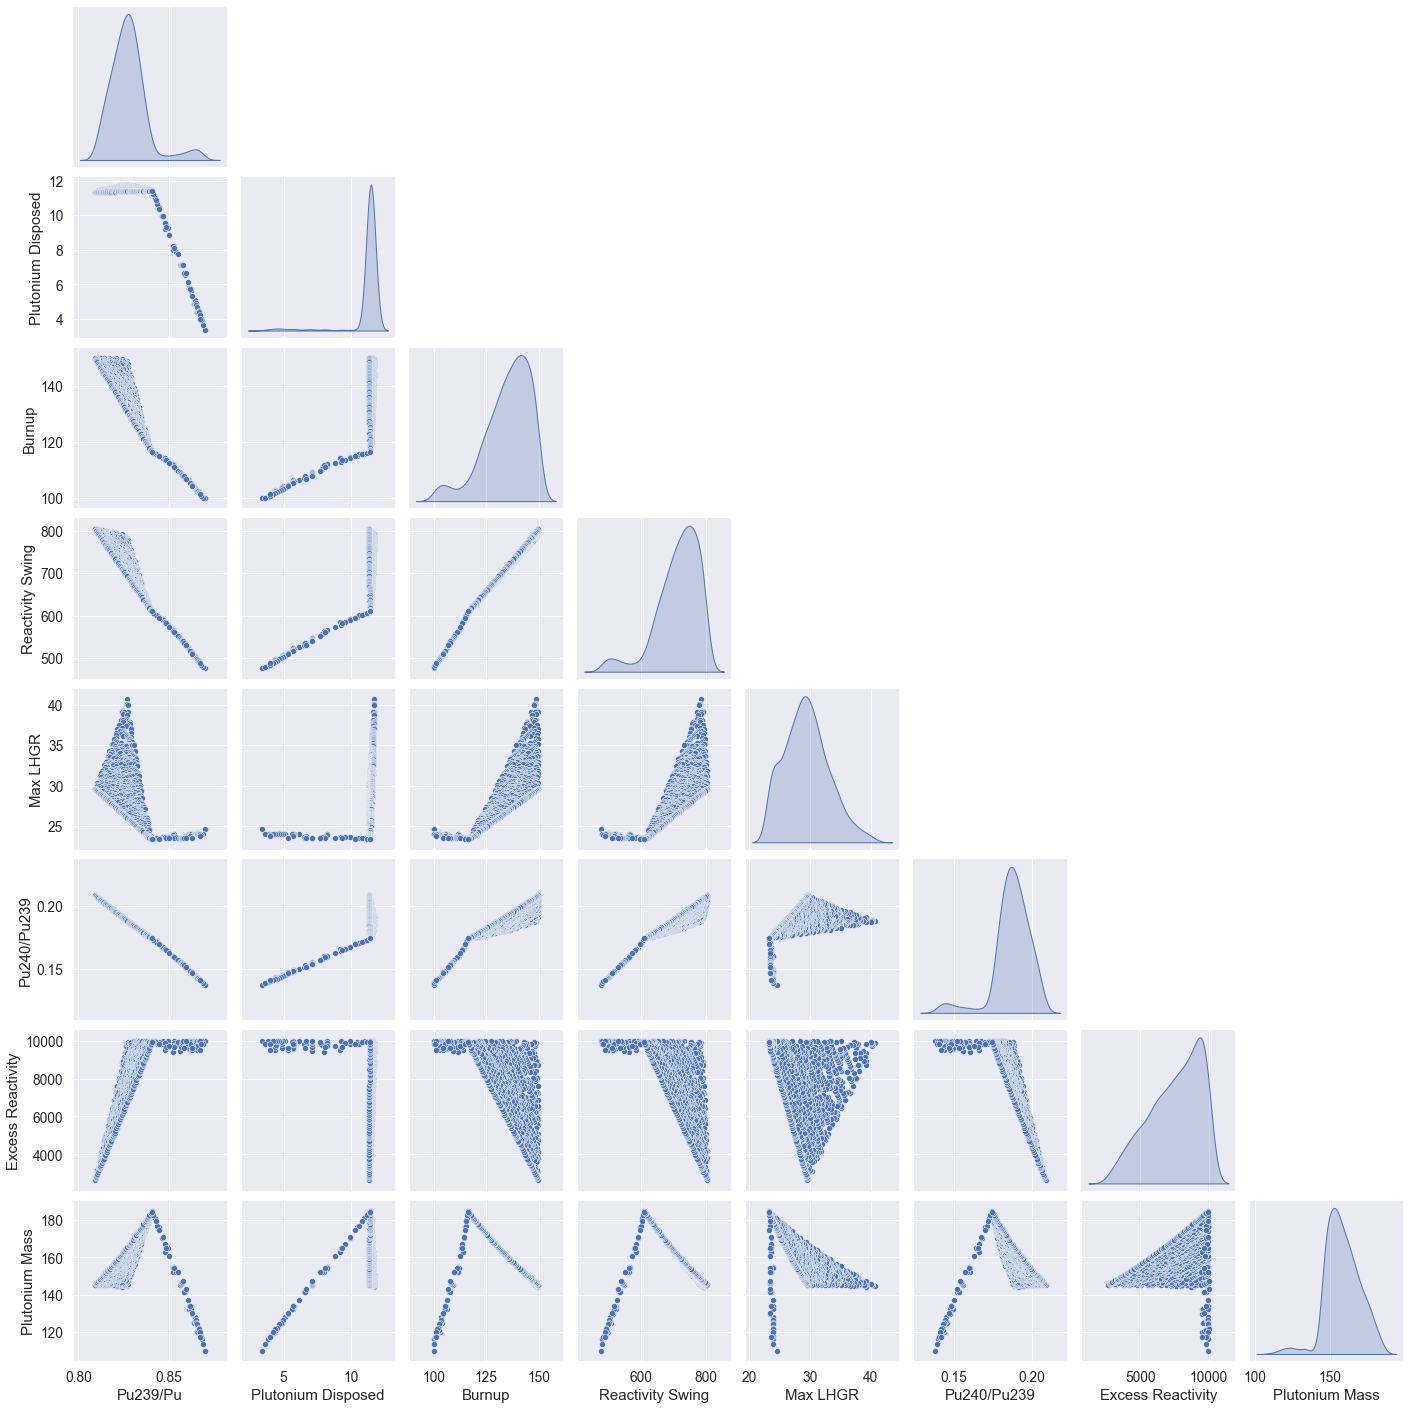

In [7]:
obj_labels = {'fitness': 'fitness',
              'burnup': 'Burnup <br>(GWD/MTHM)',
              'cycle length': 'Cycle Length (days)',
              'pu mass': 'Plutonium Mass (kg/cycle)',
              'reactivity swing' : 'Reactivity Swing (pcm/month)',
              'height': 'Height (cm)',
              'smear': 'Smear',
              'pu_content': 'Pu Frac.',
              'void': 'Void Coeff. (pcm/%void)',
              'doppler': 'Doppler Coeff. (pcm/K)',
              'excess reactivity': 'Excess Reactivity (pcm)',
              'pu ratio': 'Pu239/Pu',
              'pu240 ratio': 'Pu240/Pu239',
              'pu disposed': 'Plutonium Disposed (kg/cycle)',
              'max lhgr': 'Max LHGR (W/m)'}   
bb.set_attr(design_variables=design_variables)

objs = [x for x in bb.get_attr('objectives').keys()]
lvl_1_obj = get_objectives_in_level(lvl_1)
lvl_1_obj['smear'] = [x/100 for x in lvl_1_obj['smear']]

lvl1_df = pd.DataFrame.from_dict(lvl_1_obj)
bins = [dict(start=50,end=102.5,size=2.5), dict(start=0.5,end=0.81,size=0.01), dict(start=0,end=1.05,size=0.051)]
make_dv_histogram(bins)
x_obj = 'height'
y_obj = 'smear'
z_obj = 'pu_content'
fig = px.scatter(x=lvl_1_obj[x_obj], y=lvl_1_obj[y_obj], color=lvl_1_obj[z_obj],
                labels={'x': obj_labels[x_obj], 'y': obj_labels[y_obj], 'color': obj_labels[z_obj],})
fig.show()

x_obj = 'height'
y_obj = 'smear'
z_obj = 'burnup'
fig = px.scatter(x=lvl_1_obj[x_obj], y=lvl_1_obj[y_obj], color=lvl_1_obj[z_obj],
                labels={'x': obj_labels[x_obj], 'y': obj_labels[y_obj], 'color': obj_labels[z_obj],})
fig.show()

x_obj = 'height'
y_obj = 'smear'
z_obj = 'pu disposed'
fig = px.scatter(x=lvl_1_obj[x_obj], y=lvl_1_obj[y_obj], color=lvl_1_obj[z_obj],
                labels={'x': obj_labels[x_obj], 'y': obj_labels[y_obj], 'color': obj_labels[z_obj],})
fig.show()

x_obj = 'height'
y_obj = 'smear'
z_obj = 'pu mass'
fig = px.scatter(x=lvl_1_obj[x_obj], y=lvl_1_obj[y_obj], color=lvl_1_obj[z_obj],
                labels={'x': obj_labels[x_obj], 'y': obj_labels[y_obj], 'color': obj_labels[z_obj],})
fig.show()

x_obj = 'reactivity swing'
y_obj = 'burnup'
z_obj = 'pu mass'
fig = px.scatter(x=lvl_1_obj[x_obj], y=lvl_1_obj[y_obj], color=lvl_1_obj[z_obj],
                labels={'x': obj_labels[x_obj], 'y': obj_labels[y_obj], 'color': obj_labels[z_obj],})
fig.show()

x_obj = 'reactivity swing'
y_obj = 'burnup'
z_obj = 'pu disposed'
fig = px.scatter(x=lvl_1_obj[x_obj], y=lvl_1_obj[y_obj], color=lvl_1_obj[z_obj],
                labels={'x': obj_labels[x_obj], 'y': obj_labels[y_obj], 'color': obj_labels[z_obj],})
fig.show()

x_obj = 'pu ratio'
y_obj = 'pu disposed'
z_obj = 'max lhgr'
fig = px.scatter(x=lvl_1_obj[x_obj], y=lvl_1_obj[y_obj], color=lvl_1_obj[z_obj],
                labels={'x': obj_labels[x_obj], 'y': obj_labels[y_obj], 'color': obj_labels[z_obj],})
fig.show()

x_obj = 'pu ratio'
y_obj = 'pu disposed'
z_obj = 'pu mass'
fig = px.scatter(x=lvl_1_obj[x_obj], y=lvl_1_obj[y_obj], color=lvl_1_obj[z_obj],
                labels={'x': obj_labels[x_obj], 'y': obj_labels[y_obj], 'color': obj_labels[z_obj],})
fig.show()

x_obj = 'max lhgr'
y_obj = 'excess reactivity'
z_obj = 'void'
color = 'doppler'
fig = px.scatter_3d(x=lvl_1_obj[x_obj], y=lvl_1_obj[y_obj], z=lvl_1_obj[z_obj], color = lvl_1_obj[color],
                labels={'x': obj_labels[x_obj], 'y': obj_labels[y_obj],  
                        'z': obj_labels[z_obj], 'color': obj_labels[color]})
fig.show()

x_obj = 'height'
y_obj = 'smear'
z_obj = 'pu_content'
color = 'pu ratio'
fig = px.scatter_3d(x=lvl_1_obj[x_obj], y=lvl_1_obj[y_obj], z=lvl_1_obj[z_obj], color = lvl_1_obj[color],
                labels={'x': obj_labels[x_obj], 'y': obj_labels[y_obj],  
                        'z': obj_labels[z_obj], 'color': obj_labels[color]})
fig.show()

x_obj = 'height'
y_obj = 'smear'
z_obj = 'pu_content'
color = 'pu disposed'
fig = px.scatter_3d(x=lvl_1_obj[x_obj], y=lvl_1_obj[y_obj], z=lvl_1_obj[z_obj], color = lvl_1_obj[color],
                labels={'x': obj_labels[x_obj], 'y': obj_labels[y_obj],  
                        'z': obj_labels[z_obj], 'color': obj_labels[color]})
fig.show()

# Covariance and Statistical Analysis

obj_labels_seaborn = {'fitness': 'fitness',
              'burnup': 'Burnup',
              'pu mass': 'Plutonium Mass',
              'reactivity swing' : 'Reactivity Swing',
              'height': 'Height',
              'smear': 'Smear',
              'pu_content': 'Pu Frac.',
              'void': 'Void Coeff.',
              'doppler': 'Doppler Coeff.',
              'excess reactivity': 'Excess Reactivity',
              'pu ratio': 'Pu239/Pu',
              'pu240 ratio': 'Pu240/Pu239',
              'pu disposed': 'Plutonium Disposed',
              'max lhgr': 'Max LHGR'}  

obj_df = pd.DataFrame.from_dict(lvl_1_obj)
obj_df = obj_df.drop(columns=['height','smear','pu_content', 'void', 'doppler'])
obj_df = obj_df.rename(columns={col_name:obj_labels_seaborn[col_name] for col_name in obj_df.columns})

sns.set(font_scale=1.25)
sns.pairplot(obj_df, diag_kind='kde', corner=True)
plt.savefig('pu_pf_constraints.png')
#print()
scaler = StandardScaler()

lvl_3_obj = get_objectives_in_level(lvl_3)
obj_df_lvl3 = pd.DataFrame.from_dict(lvl_3_obj)
obj_df_lvl3 = obj_df_lvl3.drop(columns=['height','smear','pu_content'])
obj_df_lvl3 = obj_df_lvl3.rename(columns={col_name:obj_labels_seaborn[col_name] for col_name in obj_df_lvl3.columns})

scaled_data = scaler.fit_transform(obj_df_lvl3)
cov_data = np.cov(scaled_data.T)
cols = obj_df_lvl3.columns
fig = px.imshow(cov_data, x=cols, y=cols)
fig.update_layout(coloraxis=dict(colorbar=dict(x=0.75,tickmode='array',ticktext=['-1.0','-0.5','0.0','0.5','1.0'], tickvals=[-1,-.5,0,.5,1])),xaxis=dict(tickangle=45))
fig.show()

obj_df_lvl1 = pd.DataFrame.from_dict(lvl_1_obj)
#obj_df_lvl1 = obj_df_lvl1.drop(columns=['height','smear','pu_content'])
#obj_df_lvl1 = obj_df_lvl1.drop(columns=['void', 'doppler'])
obj_df_lvl1 = obj_df_lvl1.rename(columns={col_name:obj_labels_seaborn[col_name] for col_name in obj_df_lvl1.columns})

scaled_data = scaler.fit_transform(obj_df_lvl1)
cov_data = np.cov(scaled_data.T)
cols = obj_df_lvl1.columns
fig = px.imshow(cov_data, x=cols, y=cols)
fig.update_layout(coloraxis=dict(colorbar=dict(x=0.75,tickmode='array',ticktext=['-1.0','-0.5','0.0','0.5','1.0'], tickvals=[-1,-.5,0,.5,1])),xaxis=dict(tickangle=45))
fig.show()

In [ ]:
print()